In [1]:
from importlib import reload
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
import fca_lazy_clf as fca
from datetime import datetime
from sklearn.linear_model import LogisticRegression
import copy

ModuleNotFoundError: No module named 'fca_lazy_clf'

In [5]:
#https://www.kaggle.com/datasets/iamsouravbanerjee/animal-information-dataset
data = pd.read_csv('data_sets/animal_dataset_2.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Scaling

In [6]:
data = pd.read_csv('data_sets/heart.csv')
data = data.dropna()

intervals = 5
for attr in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    min_val = data[attr].min()
    max_val = data[attr].max()
    gap = max_val - min_val
    k = 0
    for i in np.linspace(min_val + gap / intervals, max_val - gap / intervals, intervals):
        data[attr + '_' + str(k)] = (data[attr] >= i).astype(int)
        k += 1
    data = data.drop(attr, axis=1)
    
for attr in ['cp', 'restecg', 'slope', 'ca', 'thal']:
    for i in data[attr].unique():
        data[attr + '_' + str(i)] = (data[attr] == i).astype(int)
    data = data.drop(attr, axis=1)

In [7]:
data.head()

,sex,fbs,exang,target,age_0,age_1,age_2,age_3,age_4,trestbps_0,...,slope_1,ca_0,ca_2,ca_1,ca_3,ca_4,thal_1,thal_2,thal_3,thal_0
0,1,1,0,1,1,1,1,1,0,1,...,0,1,0,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,1,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,1,1,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,1,1,1,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0


# Lazy classifying

In [8]:
results = {'accuracy': [], 'precision': [], 'recall': [], 'seconds': [], 'params': []}
reload(fca)

columns = list(data.columns)
columns.remove('target')

X = data.loc[:, columns]
y = data.target
for i in ['random', 'positive', 'negative']:
    for j in np.linspace(0.1, 0.9, 5):
        results = {'accuracy': [], 'precision': [], 'recall': [], 'seconds': []}
        clf = fca.LazyClassifier(threshold=j, bias=i, random=True, sample_share=0.3)
        
        print()
        print('Parameters:', clf)
        print()
        
        for k in range(10):

            X_train, X_test, y_train, y_test = model_selection\
                .train_test_split(X, y, test_size=0.33, random_state=k)

            clf.fit(X_train, y_train)

            s = datetime.now()
            y_pred = clf.predict(X_test)
            f = datetime.now()

            results['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
            results['precision'].append(metrics.precision_score(y_test, y_pred))
            results['recall'].append(metrics.recall_score(y_test, y_pred))
            results['seconds'].append((f - s).seconds)
           

        print(pd.DataFrame(results))
        print()
        print('Accuracy:', pd.DataFrame(results)['accuracy'].mean())


Parameters: LazyClassifier(random=True, sample_share=0.3, threshold=0.1)
   accuracy  precision    recall  seconds
0      0.81   0.883721  0.730769        0
1      0.77   0.860465  0.685185        0
2      0.87   0.923077  0.842105        0
3      0.84   0.886792  0.824561        0
4      0.83   0.901961  0.793103        0
5      0.78   0.900000  0.666667        0
6      0.84   0.880952  0.770833        0
7      0.81   0.779661  0.884615        0
8      0.81   0.901961  0.766667        0
9      0.77   0.882353  0.725806        0

Accuracy: 0.813

Parameters: LazyClassifier(random=True, sample_share=0.3, threshold=0.30000000000000004)
   accuracy  precision    recall  seconds
0      0.82   0.886364  0.750000        0
1      0.71   0.857143  0.555556        0
2      0.86   0.938776  0.807018        0
3      0.81   0.880000  0.771930        0
4      0.80   0.931818  0.706897        0
5      0.80   0.972222  0.648148        0
6      0.84   0.833333  0.833333        0
7      0.83   0.79661

In [9]:
reload(fca)

columns = list(data.columns)
columns.remove('target')

X = data.loc[:, columns]
y = data.target

results = {'accuracy': [], 'precision': [], 'recall': [], 'seconds': []}
clf = fca.LazyClassifier(threshold=0.9, bias='negative')
for k in range(10):

    X_train, X_test, y_train, y_test = model_selection\
        .train_test_split(X, y, test_size=0.33, random_state=k)

    clf.fit(X_train, y_train)

    s = datetime.now()
    y_pred = clf.predict(X_test)
    f = datetime.now()

    results['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
    results['precision'].append(metrics.precision_score(y_test, y_pred))
    results['recall'].append(metrics.recall_score(y_test, y_pred))
    results['seconds'].append((f - s).seconds)

print(pd.DataFrame(results))
print()
print('Accuracy:', pd.DataFrame(results)['accuracy'].mean())

   accuracy  precision    recall  seconds
0      0.83   0.906977  0.750000        3
1      0.75   0.853659  0.648148        3
2      0.85   0.920000  0.807018        3
3      0.83   0.884615  0.807018        3
4      0.80   0.895833  0.741379        3
5      0.83   0.930233  0.740741        3
6      0.84   0.863636  0.791667        2
7      0.85   0.849057  0.865385        3
8      0.79   0.933333  0.700000        3
9      0.72   0.826923  0.693548        3

Accuracy: 0.8089999999999999


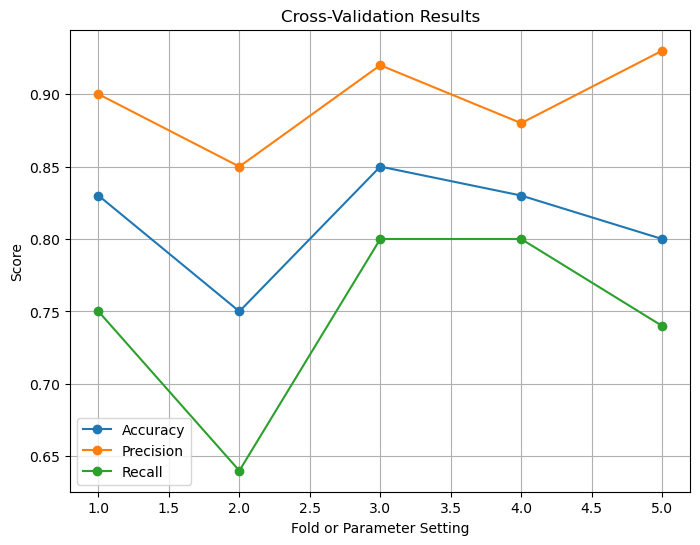

In [2]:
import matplotlib.pyplot as plt

# Assuming cv_results is a dictionary containing cross-validation scores
# For example:
cv_results = {
    'accuracy': [0.83, 0.75, 0.85, 0.83, 0.80],  # Mean accuracy scores for each fold or parameter setting
    'precision': [0.90, 0.85, 0.92, 0.88, 0.93],  # Mean precision scores
    'recall': [0.75, 0.64, 0.80, 0.80, 0.74]  # Mean recall scores
}

# Plotting the cross-validation results
plt.figure(figsize=(8, 6))

# Plotting mean accuracy
plt.plot(range(1, len(cv_results['accuracy']) + 1), cv_results['accuracy'], marker='o', label='Accuracy')
# Plotting mean precision
plt.plot(range(1, len(cv_results['precision']) + 1), cv_results['precision'], marker='o', label='Precision')
# Plotting mean recall
plt.plot(range(1, len(cv_results['recall']) + 1), cv_results['recall'], marker='o', label='Recall')

plt.xlabel('Fold or Parameter Setting')
plt.ylabel('Score')
plt.title('Cross-Validation Results')
plt.legend()
plt.grid(True)
plt.show()
